In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("../data/single_series.csv", index_col =False)
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)

In [3]:
df = df[::-1]

In [4]:
df.head()

,Open
Date,
2013-04-28,135.30
2013-04-29,134.44
2013-04-30,144.00
2013-05-01,139.00
2013-05-02,116.38


In [5]:
df

,Open
Date,
2013-04-28,135.30
2013-04-29,134.44
2013-04-30,144.00
2013-05-01,139.00
2013-05-02,116.38
...,...
2017-07-27,2538.71
2017-07-28,2679.73
2017-07-29,2807.02


<AxesSubplot:xlabel='Date'>

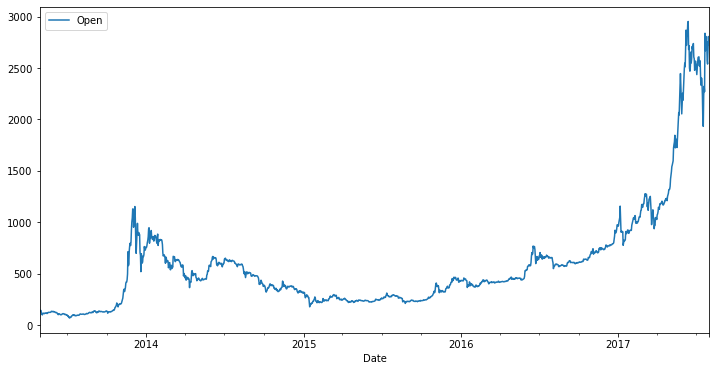

In [6]:
df.plot(figsize=(12,6))

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

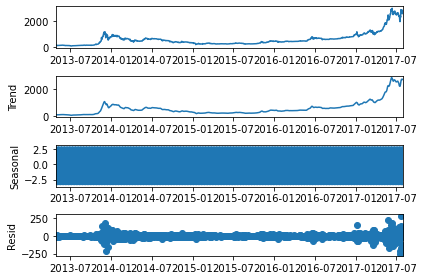

In [8]:
results = seasonal_decompose(df)
results.plot();

In [9]:
df.shape

(1556, 1)

In [10]:
(1556/100)*70

1089.2

In [11]:
df_train = df.iloc[:1300]
df_test = df.iloc[1300:]

test_df = df_test.copy()

In [12]:
df_train.iloc[0]

Open    135.3
Name: 2013-04-28 00:00:00, dtype: float64

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [14]:
scaler.fit(df_train)
df_train = scaler.transform(df_train)
df_test = scaler.transform(df_test)

In [15]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [16]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(df_train, df_train, length=n_input, batch_size=1)

In [17]:
df_train[:5]

array([[0.06161054],
       [0.06081735],
       [0.06963467],
       [0.0650231 ],
       [0.04416037]])

In [18]:
generator[0]

(array([[[0.06161054],
         [0.06081735],
         [0.06963467],
         [0.0650231 ],
         [0.04416037],
         [0.03481734],
         [0.02730048],
         [0.04095072],
         [0.04379145],
         [0.04035122],
         [0.03790709],
         [0.04122741]]]),
 array([[0.04085849]]))

In [19]:
x,y = generator[0]
x.flatten(),y.flatten()

(array([0.06161054, 0.06081735, 0.06963467, 0.0650231 , 0.04416037,
        0.03481734, 0.02730048, 0.04095072, 0.04379145, 0.04035122,
        0.03790709, 0.04122741]),
 array([0.04085849]))

In [20]:
x.shape

(1, 12, 1)

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import *

In [22]:
model = Sequential()
model.add(InputLayer((n_input, n_features)))
model.add(LSTM(128))
model.add(Dense(8,'relu'))
model.add(Dense(1,'linear'))
model.compile(optimizer='adam', loss='mse')


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 67,601
Trainable params: 67,601
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(generator,epochs=50)

Epoch 1/50
1288/1288 [==============================] - 4s 2ms/step - loss: 0.0032
Epoch 2/50
1288/1288 [==============================] - 3s 2ms/step - loss: 0.0014
Epoch 3/50
1288/1288 [==============================] - 4s 3ms/step - loss: 9.5598e-04
Epoch 4/50
1288/1288 [==============================] - 3s 2ms/step - loss: 9.0565e-04
Epoch 5/50
1288/1288 [==============================] - 3s 2ms/step - loss: 8.2859e-04
Epoch 6/50
1288/1288 [==============================] - 3s 2ms/step - loss: 6.7448e-04
Epoch 7/50
1288/1288 [==============================] - 3s 2ms/step - loss: 6.8610e-04
Epoch 8/50
1288/1288 [==============================] - 3s 2ms/step - loss: 7.5564e-04
Epoch 9/50
1288/1288 [==============================] - 3s 2ms/step - loss: 6.7553e-04
Epoch 10/50
1288/1288 [==============================] - 3s 2ms/step - loss: 6.5839e-04
Epoch 11/50
1288/1288 [==============================] - 3s 2ms/step - loss: 6.6186e-04
Epoch 12/50
1288/1288 [==========================

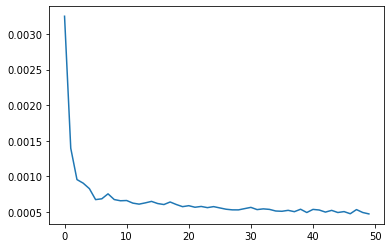

In [25]:
import matplotlib.pyplot as plt

loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [27]:
dummy_test = df_train[-n_input:]
dummy_test = dummy_test.reshape((1,n_input,n_features))

In [28]:
dummy_test_pred = df_test[0]
dummy_test, dummy_test_pred

(array([[[0.58595501],
         [0.59234664],
         [0.58529094],
         [0.59150734],
         [0.60350664],
         [0.59678297],
         [0.59788975],
         [0.58723703],
         [0.58428562],
         [0.58778119],
         [0.59274324],
         [0.62383443]]]),
 array([0.61998838]))

In [29]:
model.predict(dummy_test)

array([[0.61725104]], dtype=float32)

In [30]:
test_predictions = []

first_batch = df_train[-n_input:]
current_batch = first_batch.reshape((1, n_input, n_features))

for i in range(len(df_test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [31]:
true_predictions = scaler.inverse_transform(test_predictions)

In [32]:
test_df['Predictions'] = true_predictions

<AxesSubplot:xlabel='Date'>

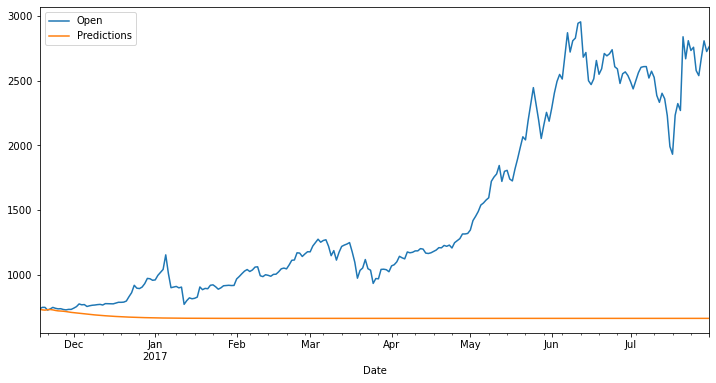

In [33]:
test_df.plot(figsize = (12,6))